# Run Maxent model

In [1]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 'leptocybe-invasa' # 
pseudoabsence = 'random' # 'biased-land-cover' # 'biased' # 'random' # 
training = 'east-asia'# 'australia' # 
interest = 'south-east-asia'
bioclim = [i for i in range(1,20)] # [1, 5, 6, 12, 13, 14] # [1, 16, 6, 11] # [10, 16, 14] # [1,2,6,11,13,15,16] #
topo = True
savefig = False

###########################################################

In [2]:
import os

import math
import numpy as np

import xarray as xr
import rioxarray as rioxr
import pandas as pd
import geopandas as gpd

import elapid as ela
from sklearn import metrics, inspection

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore")

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
def subplot_layout(nplots):

    ncols = min(int(np.ceil(np.sqrt(nplots))), 4)
    nrows = int(np.ceil(nplots / ncols))
    
    return ncols, nrows

In [4]:
# data_path = os.path.join(os.sep, 'scratch', 'aciar-fst', 'data')
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
figs_path = os.path.join(os.path.dirname(os.getcwd()), 'figs')
docs_path = os.path.join(os.path.dirname(os.getcwd()), 'docs')
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
input_path = os.path.join(out_path, 'input')
train_path = os.path.join(input_path, 'train')
test_path = os.path.join(input_path, 'test')
output_path = os.path.join(out_path, 'output')
if not os.path.exists(output_path):
    os.makedirs(output_path)

Load shapefiles of training and test regions

In [5]:
# select and combine countries in one dataframe
gdf_countries = {}
for region in [training, interest]:
    file_path = train_path if region == training else test_path
    gdf_countries[region] = gpd.read_file(os.path.join(file_path, '%s.shp' %region))

## 1. Train model for region of specie occurences

### 1.1 load predictive variable data

In [6]:
rasters, labels = (['srtm_%s.tif' %training], ['srtm']) if topo else ([], []) # 'ndvi_east-asia.tif', 'ndvi' # 

for no in bioclim:
    rasters.append('wc2.1_10m_bio_%s_%s.tif' %(no, training))
    labels.append('bioclim_%02d' %no)

raster_paths = [os.path.join(input_path, 'train', raster) for raster in rasters]
# rasters, raster_paths, labels

# initialise dataset for model output
training_output = xr.Dataset()
for raster, label in zip(raster_paths, labels):
    da = rioxr.open_rasterio(raster, masked=True)
    training_output[label] = da

### 1.2 load and merge presence and background data

In [7]:
presence_file_name = '%s_presence_%s.csv' %(specie, training)
background_file_name = '%s_background_%s_%s.csv' %(specie, pseudoabsence, training)
train_input_data_name = 'model-train_input-data_%s_%s_%s.csv' %(specie, pseudoabsence, training)

presence_csv = pd.read_csv(os.path.join(input_path, 'train', presence_file_name))
geometry = gpd.points_from_xy(presence_csv['lon'], presence_csv['lat'])
presence_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

background_csv = pd.read_csv(os.path.join(input_path, 'train', background_file_name))
geometry = gpd.points_from_xy(background_csv['lon'], background_csv['lat'])
background_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

In [8]:
presence_train = ela.annotate(
    presence_gdf.geometry,
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

background_train = ela.annotate(
    background_gdf, #pseudoabsence_random, pseudoabsence_bias_eucalyptus, #pseudoabsence_bias_perc_planted
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

train = ela.stack_geodataframes(
    presence_train,
    background_train,
    add_class_label=True,
)

Raster:   0%|                              | 0/20 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Sample:   0%|                              | 0/36 [00:00<?, ?it/s]

Raster:   0%|                              | 0/20 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

In [9]:
train.describe()

,srtm,bioclim_01,bioclim_02,bioclim_03,bioclim_04,bioclim_05,bioclim_06,bioclim_07,bioclim_08,bioclim_09,...,bioclim_11,bioclim_12,bioclim_13,bioclim_14,bioclim_15,bioclim_16,bioclim_17,bioclim_18,bioclim_19,class
count,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.00000,9939.000000,9939.000000,9939.000000,...,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000,9939.000000
mean,1677.883892,6.459000,11.418654,30.485964,1020.602576,24.775531,-13.77382,38.868095,17.345206,-4.772311,...,-6.166717,623.709830,128.388872,10.683670,87.164805,327.538183,39.221451,310.038837,44.274575,0.003421
std,1665.066908,7.339413,2.755024,6.332448,307.701305,6.985237,10.71728,9.669868,7.017477,9.557116,...,9.291173,532.949727,91.561655,16.709423,24.136344,240.805394,58.452394,220.542119,68.207070,0.058391
min,-88.000000,-16.000000,4.000000,17.000000,283.000000,2.000000,-36.00000,14.000000,-14.000000,-26.000000,...,-27.000000,13.000000,4.000000,0.000000,19.000000,9.000000,0.000000,9.000000,0.000000,0.000000
25%,388.500000,0.000000,10.000000,26.000000,796.000000,21.000000,-22.00000,31.000000,14.000000,-12.000000,...,-13.000000,188.000000,44.000000,1.000000,68.000000,110.000000,6.000000,105.000000,6.000000,0.000000
50%,1049.000000,6.000000,12.000000,29.000000,970.000000,27.000000,-16.00000,39.000000,19.000000,-6.000000,...,-7.000000,489.000000,127.000000,3.000000,91.000000,317.000000,14.000000,312.000000,14.000000,0.000000
75%,2600.000000,12.000000,13.000000,34.000000,1256.000000,30.000000,-4.00000,47.000000,22.000000,3.000000,...,1.000000,938.000000,187.000000,12.000000,105.000000,470.000000,44.000000,450.000000,48.000000,0.000000
max,6251.000000,25.000000,18.000000,53.000000,1747.000000,41.000000,17.00000,61.000000,31.000000,22.000000,...,21.000000,3430.000000,783.000000,183.000000,150.000000,2024.000000,579.000000,2024.000000,699.000000,1.000000


### 1.3 run model

In [10]:
experiment_name = 'exp_%s_%s_%s' %(pseudoabsence, training, interest)
run_name = 'model-train_%s_%s_%s.ela' %(specie, pseudoabsence, training)
nc_name = 'model-train_%s_%s_%s.nc' %(specie, pseudoabsence, training)
raster_name = 'model-train_%s_%s_%s.tif' %(specie, pseudoabsence, training)

exp_path = os.path.join(output_path, experiment_name)
if not os.path.exists(exp_path):
    os.makedirs(exp_path)

In [11]:
# write model input data to csv
train.to_csv(os.path.join(exp_path, train_input_data_name))

# split the x/y data
x_train = train.drop(columns=['class', 'geometry'])
y_train = train['class']

# train the model
model_train = ela.MaxentModel(transform='logistic', beta_multiplier=1.5)
print(model_train.get_params())
model_train.fit(x_train, y_train)

# write the fitted model to file
ela.save_object(model_train, os.path.join(exp_path, run_name))

{'beta_categorical': 1.0, 'beta_hinge': 1.0, 'beta_lqp': 1.0, 'beta_multiplier': 1.5, 'beta_threshold': 1.0, 'clamp': True, 'class_weights': 100, 'convergence_tolerance': 2e-06, 'feature_types': ['linear', 'hinge', 'product'], 'n_cpus': 32, 'n_hinge_features': 10, 'n_lambdas': 100, 'n_threshold_features': 10, 'scorer': 'roc_auc', 'tau': 0.5, 'transform': 'logistic', 'use_lambdas': 'best', 'use_sklearn': True}


In [12]:
# predict the model
y_train_predict = model_train.predict(x_train)

# save the environment variables and model predictions to xarray.Dataset
array = training_output.isel(band=0).to_array().values
nodata = np.nan
nodata_idx = np.isnan(array)
rop = ela.geo.apply_model_to_array(model_train, array, nodata, nodata_idx)

training_output['rop'] = (('band', 'y', 'x'), rop)
training_output['rop'].attrs['long_name'] = "relative occurrence probability"

# write model output to netcdf
training_output.to_netcdf(os.path.join(exp_path, nc_name))

# write model predictions to raster
ela.apply_model_to_rasters(model_train, raster_paths, os.path.join(exp_path, raster_name), quiet=True)

In [13]:
# model training performance

# ROC-curve
# fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_predict)

# PR-curve
precision_train, recall_train, _= metrics.precision_recall_curve(y_train, y_train_predict) 
pr_auc_train = metrics.auc(recall_train, precision_train)

print(f"Training ROC-AUC score: {auc_train:0.3f}")
print(f"PR-AUC Score: {pr_auc_train:0.3f}")

Training ROC-AUC score: 0.980
PR-AUC Score: 0.474


In [14]:
# fig, ax = plt.subplots(ncols=3, figsize=(18,6),constrained_layout=True)

# ax[0].hist(y_train_predict[y_train==0], bins=np.linspace(0,1,int((y_train==0).sum()/100 + 1)), density=True, color='tab:red', alpha=0.7, label='pseudo-absence')
# ax[0].hist(y_train_predict[y_train==1], bins=np.linspace(0,1,int((y_train==1).sum()/10+1)), density=True, color='tab:green', alpha=0.7, label='presence')

# ax[0].set_xlabel('Relative Occurrence Probability')
# ax[0].set_ylabel('Counts')
# ax[0].set_title('Probability Distribution')

# ax[0].legend(loc='upper right')

# ax[1].plot([0, 1], [0, 1], '--', label=f'AUC score: 0.5 (No Skill)', color='gray')
# ax[1].text(0.4, 0.4, 'random classifier', fontsize=12, color='gray',
#            rotation=45, rotation_mode='anchor', horizontalalignment='left',
#            verticalalignment='bottom',transform=ax[1].transAxes)

# ax[1].plot([0, 0, 1], [0, 1, 1], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
# ax[1].text(0, 1, '  perfect classifier', fontsize=12, color='tab:blue', 
#            horizontalalignment='left', verticalalignment='bottom')
# ax[1].scatter(0, 1, marker='*', s=100, color='tab:blue')

# ax[1].plot(fpr_train, tpr_train, label=f'AUC score: {auc_train:0.3f}', color='tab:orange')
# ax[1].axis('equal')
# ax[1].set_xlabel('False Positive Rate')
# ax[1].set_ylabel('True Positive Rate')
# ax[1].set_title('MaxEnt ROC Curve')
# ax[1].legend(loc='lower right')

# ax[2].plot([0, 1], [0.5, 0.5], '--', color='gray', label=f'AUC score: 0.5 (No Skill)')
# ax[2].text(0.5, 0.52, 'random classifier', fontsize=12, color='gray',
#            horizontalalignment='center', verticalalignment='center')
# ax[2].plot([0, 1, 1], [1, 1, 0], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
# ax[2].text(1, 1, 'perfect classifier  ', fontsize=12, color='tab:blue', 
#            horizontalalignment='right', verticalalignment='bottom')
# ax[2].scatter(1, 1, marker='*', s=100, color='tab:blue')

# ax[2].plot(recall_train, precision_train, label=f'AUC score: {pr_auc_train:0.3f}', color='tab:orange')
# ax[2].axis('equal')
# ax[2].set_xlabel('Recall')
# ax[2].set_ylabel('Precision')
# ax[2].set_title('MaxEnt PR Curve')
# ax[2].legend(loc='lower left')


## 2. Predict model for region of interest

### 2.1 load test data

In [15]:
rasters, labels = (['srtm_%s.tif' %interest], ['srtm']) if topo else ([], []) # 'ndvi_east-asia.tif', 'ndvi' # 
for no in bioclim:
    rasters.append('wc2.1_10m_bio_%s_%s.tif' %(no, interest))
    labels.append('bioclim_%02d' %no)

raster_paths = [os.path.join(input_path, 'test', raster) for raster in rasters]

# initialise dataset for model output
test_output = xr.Dataset()
for raster, label in zip(raster_paths, labels):
    da = rioxr.open_rasterio(raster, masked=True)
    test_output[label] = da

In [16]:
presence_file_name = '%s_presence_%s.csv' %(specie, interest)
background_file_name = '%s_background_%s_%s.csv' %(specie, pseudoabsence, interest)
test_input_data_name = 'model-test_input-data_%s_%s_%s.csv' %(specie, pseudoabsence, interest)

presence_csv = pd.read_csv(os.path.join(input_path, 'test', presence_file_name))
geometry = gpd.points_from_xy(presence_csv['lon'], presence_csv['lat'])
presence_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

background_csv = pd.read_csv(os.path.join(input_path, 'test', background_file_name))
geometry = gpd.points_from_xy(background_csv['lon'], background_csv['lat'])
background_gdf = gpd.GeoDataFrame(geometry=geometry, crs='EPSG:4326')

In [17]:
if len(presence_gdf) == 0:
    print('There are no occurrences of this specie in this region!')
    # chose arbitrary coordinate to make the code run
    presence_gdf.geometry=gpd.points_from_xy([115], [0])

In [18]:
presence_test = ela.annotate(
    presence_gdf.geometry,
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

background_test = ela.annotate(
    background_gdf, #pseudoabsence_random, pseudoabsence_bias_eucalyptus, #pseudoabsence_bias_perc_planted
    raster_paths=raster_paths, 
    labels=labels, 
    drop_na=True,
)

test = ela.stack_geodataframes(
    presence_test,
    background_test,
    add_class_label=True,
)

test.to_csv(os.path.join(exp_path, test_input_data_name))

Raster:   0%|                              | 0/20 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Sample:   0%|                              | 0/11 [00:00<?, ?it/s]

Raster:   0%|                              | 0/20 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

### 2.2 model predict for region of interest/ test data

In [19]:
nc_name = 'model-test_%s_%s_%s.nc' %(specie, pseudoabsence, interest)
raster_name = 'model-test_%s_%s_%s.tif' %(specie, pseudoabsence, interest)

In [20]:
# split the x/y data
x_test = test.drop(columns=['class', 'geometry'])
y_test = test['class']

# predict the model for the test data
y_test_predict = model_train.predict(x_test)

# save the environment variables and model predictions to xarray.Dataset
array = test_output.isel(band=0).to_array().values
nodata = np.nan
nodata_idx = np.isnan(array)
rop = ela.geo.apply_model_to_array(model_train, array, nodata, nodata_idx)

test_output['rop'] = (('band', 'y', 'x'), rop)
test_output['rop'].attrs['long_name'] = "relative occurrence probability"

# write model output to netcdf
test_output.to_netcdf(os.path.join(exp_path, nc_name))

# write model predictions to raster
ela.apply_model_to_rasters(model_train, raster_paths, os.path.join(exp_path, raster_name), quiet=True)

### 2.3 test data performance

In [21]:
# ROC-curve
# fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_predict)

# PR-curve
precision_test, recall_test, _= metrics.precision_recall_curve(y_test, y_test_predict) 
pr_auc_test = metrics.auc(recall_test, precision_test)

print(f"Training ROC-AUC score: {auc_train:0.3f}")
print(f"Training PR-AUC Score: {pr_auc_train:0.3f}")

print(f"Test ROC-AUC score: {auc_test:0.3f}")
print(f"Test PR-AUC Score: {pr_auc_test:0.3f}")

Training ROC-AUC score: 0.980
Training PR-AUC Score: 0.474
Test ROC-AUC score: 0.624
Test PR-AUC Score: 0.002


In [22]:
# fig, ax = plt.subplots(ncols=3, figsize=(18,6),constrained_layout=True)

# # 
# ax[0].hist(y_test_predict[y_test==0], bins=np.linspace(0,1,int((y_test==0).sum()/100 + 1)), density=True, color='tab:red', alpha=0.7, label='pseudo-absence')
# ax[0].hist(y_test_predict[y_test==1], bins=np.linspace(0,1,int((y_test==1).sum()/10+1)), density=True, color='tab:green', alpha=0.7, label='presence')

# ax[0].set_xlabel('Relative Occurrence Probability')
# ax[0].set_ylabel('Counts')
# ax[0].set_title('Probability Distribution')

# ax[0].legend(loc='upper right')

# ax[1].plot([0, 1], [0, 1], '--', label=f'AUC score: 0.5 (No Skill)', color='gray')
# ax[1].text(0.4, 0.4, 'random classifier', fontsize=12, color='gray',
#            rotation=45, rotation_mode='anchor', horizontalalignment='left',
#            verticalalignment='bottom',transform=ax[1].transAxes)

# ax[1].plot([0, 0, 1], [0, 1, 1], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
# ax[1].text(0, 1, '  perfect classifier', fontsize=12, color='tab:blue', 
#            horizontalalignment='left', verticalalignment='bottom')
# ax[1].scatter(0, 1, marker='*', s=100, color='tab:blue')

# ax[1].plot(fpr_train, tpr_train, label=f'AUC train score: {auc_train:0.3f}', color='tab:orange')
# ax[1].plot(fpr_test, tpr_test, label=f'AUC test score: {auc_test:0.3f}', color='tab:green')

# ax[1].axis('equal')
# ax[1].set_xlabel('False Positive Rate')
# ax[1].set_ylabel('True Positive Rate')
# ax[1].set_title('MaxEnt ROC Curve')
# ax[1].legend(loc='lower right')

# ## 
# ax[2].plot([0, 1], [0.5, 0.5], '--', color='gray', label=f'AUC score: 0.5 (No Skill)')
# ax[2].text(0.5, 0.52, 'random classifier', fontsize=12, color='gray',
#            horizontalalignment='center', verticalalignment='center')
# ax[2].plot([0, 1, 1], [1, 1, 0], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
# ax[2].text(1, 1, 'perfect classifier  ', fontsize=12, color='tab:blue', 
#            horizontalalignment='right', verticalalignment='bottom')
# ax[2].scatter(1, 1, marker='*', s=100, color='tab:blue')


# ax[2].plot(recall_train, precision_train, label=f'AUC train score: {pr_auc_train:0.3f}', color='tab:orange')
# ax[2].plot(recall_test, precision_test, label=f'AUC test score: {pr_auc_test:0.3f}', color='tab:green')

# ax[2].axis('equal')
# ax[2].set_xlabel('Recall')
# ax[2].set_ylabel('Precision')
# ax[2].set_title('MaxEnt PR Curve')
# ax[2].legend(loc='lower left')


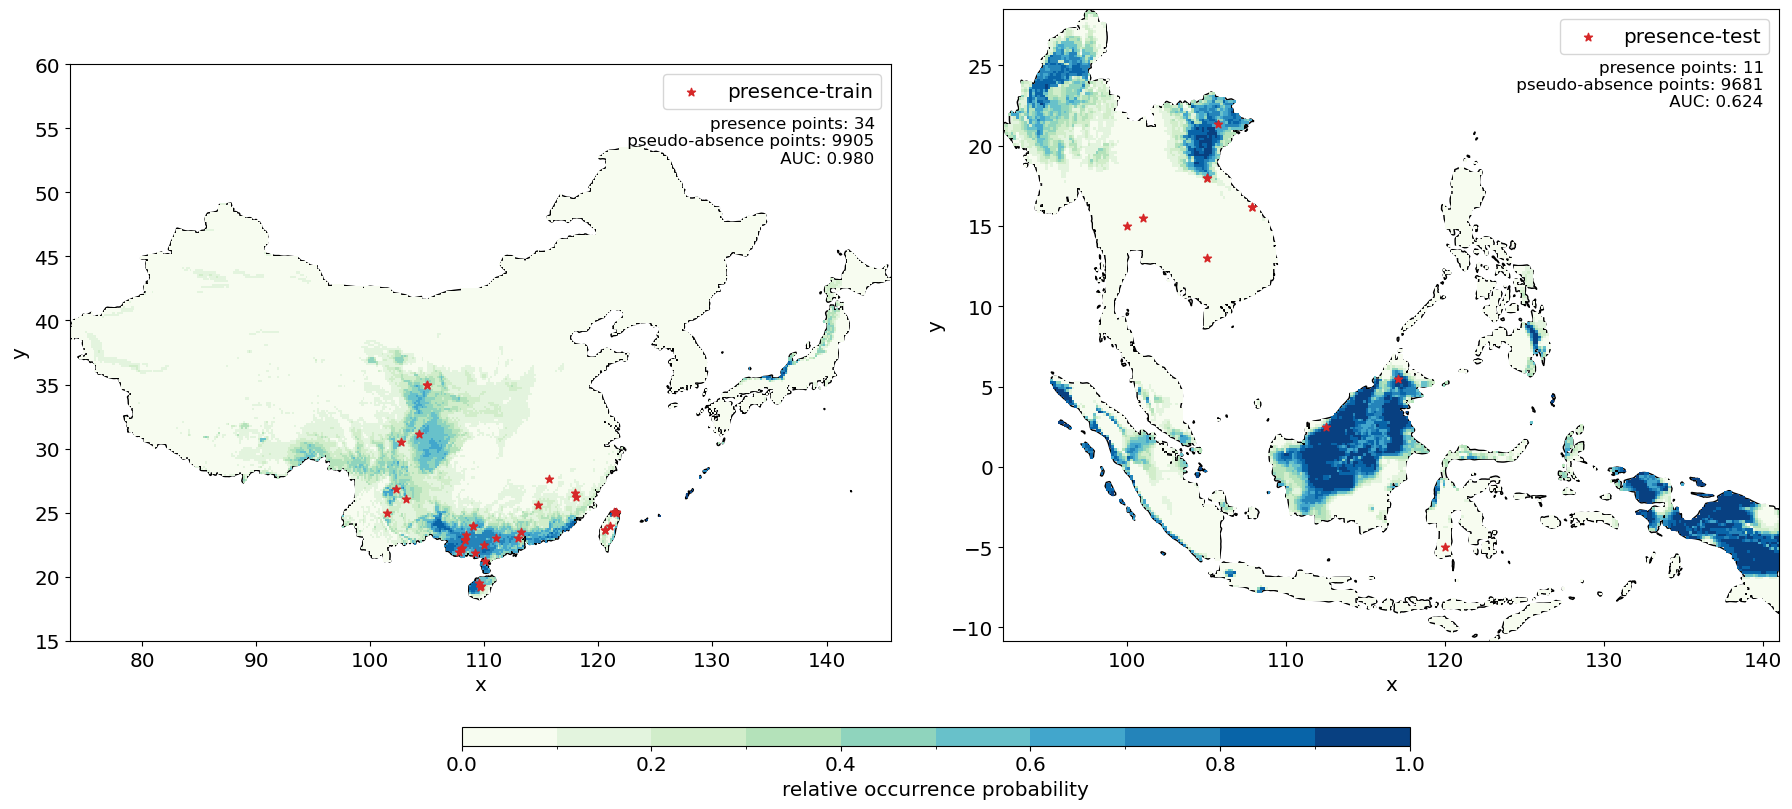

In [41]:
doc=False

fig, ax = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True) #dpi=100

cmap = plt.cm.GnBu #'GnBu'
bounds = np.linspace(0, 1, 11)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# pcol = train_out.plot(ax=ax[0], vmin=0, vmax=1, cmap='GnBu', add_colorbar=False)
gdf_countries[training].plot(ax=ax[0], facecolor='lightgray', edgecolor='k')
pcol = training_output.rop.plot(ax=ax[0], vmin=0, vmax=1, norm=norm, cmap=cmap, add_colorbar=False)
presence_train.plot(ax=ax[0], color='tab:red', marker='*', label='presence-train')
ax[0].text(0.98, 0.91, 'presence points: %s\n pseudo-absence points: %s\n AUC: %.3f' %(len(presence_train), len(background_train), auc_train), fontsize=12, 
           horizontalalignment='right', verticalalignment='top', transform=ax[0].transAxes)
ax[0].legend(loc='upper right')
ax[0].set_title('')
ax[0].set_ylim([15, 60])

gdf_countries[interest].plot(ax=ax[1], facecolor='lightgray', edgecolor='k')
pcol = test_output.rop.plot(ax=ax[1], vmin=0, vmax=1, norm=norm, cmap=cmap, add_colorbar=False)
presence_test.plot(ax=ax[1], color='tab:red', marker='*', label='presence-test')
ax[1].text(0.98, 0.92, 'presence points: %s\n pseudo-absence points: %s\n AUC: %.3f' %(len(presence_test), len(background_test), auc_test), fontsize=12, 
           horizontalalignment='right', verticalalignment='top', transform=ax[1].transAxes)
ax[1].legend()
ax[1].set_title('')

cbar = fig.colorbar(pcol, ax=ax, aspect=50, pad=0.05, label="relative occurrence probability", orientation='horizontal', fraction=0.03)

if doc:
    ax[0].axis('off')
    ax[1].axis('off')

    if savefig:
        fig.savefig(os.path.join(docs_path, '05_rel-occ-prob-_%s_%s.png' %(training, interest)), transparent=True, bbox_inches='tight')

In [24]:
if savefig:
    fig.savefig(os.path.join(figs_path, '05_rel-occ-prob-_%s_%s_%s.png' %(specie, training, interest)), transparent=True, bbox_inches='tight')

In [25]:
test_output.close()

In [26]:
# cmap = plt.cm.GnBu #'GnBu'
# bounds = np.linspace(0, 1, 5)
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# fig, ax = plt.subplots(figsize=(8,6))

# gdf_countries[training].plot(ax=ax, facecolor='lightgray', edgecolor='k')
# pcol = training_output.rop.plot(ax=ax, vmin=0, vmax=1, norm=norm, cmap=cmap, add_colorbar=False)
# presence_train.plot(ax=ax, color='tab:orange', marker='*')

# ax.set_title('')
# ax.axis('off')
# fig.colorbar(pcol, fraction=0.02)
# fig.savefig(os.path.join(figs_path, '07_maxent-prob-occ_%s.png' %region), transparent=True, dpi=600)